<a href="https://colab.research.google.com/github/alexcontarino/personal-projects/blob/main/March_Madness_Ballot_Game/Linear_Programming_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal:
 Optimize the probability of a (likely) winning score (say, $\geq 18$ wins) by buying a mix of teams subject to the cost constraint.

## Method:
1. Choose a set number of teams to buy (4, 6, etc.)
1. Choose the optimal mix of seeds to maximize the expectation of wins (linear programming)
1. Simulate tournament results with chosen teams
1. Compute probability of achieving win threshold (18 wins)
1. Repeat for all possible number of teams that could be bought (4 to 34).

## Motivation:
Because we're trying to maximize the probablility of a relatively rare event (winning), there is an element of luck (variance) involved. Picking a few good teams may have the best expectation, but few teams means small range of outcomes. Conversely, picking many poor teams may have a low expectation for wins but a wide range of outcomes. Which strategy gives us a better chance of achieving 18 wins?

## Set-Up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import Counter
import pickle
from google.colab import files
import pandas as pd
import scipy.stats

%pip install pulp
from pulp import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 25.4 MB/s eta 0:00:00


In [2]:
# Seed info: cost and probability of making next round based on historical results
seed1 = {"cost": 25,
         "round_prb": [1, 139/140, 120/140, 97/140, 57/140, 34/140, 22/140]}
seed2 = {"cost": 19,
         "round_prb": [1, 132/140, 89/140, 64/140, 29/140, 13/140, 5/140]}
seed3 = {"cost": 13,
         "round_prb": [1, 119/140, 74/140, 36/140, 17/140, 11/140, 4/140]}

seed4 = {"cost": 12,
         "round_prb": [1, 111/140, 66/140, 21/140, 13/140, 6/140, 1/140]}

seed5 = {"cost": 11,
         "round_prb": [1, 90/140, 47/140, 9/140, 7/140, 3/140, 1/140]}

seed6 = {"cost": 10,
         "round_prb": [1, 88/140, 42/140, 14/140, 4/140, 2/140, 1/140]}

seed7 = {"cost": 8,
         "round_prb": [1, 85/140, 27/140, 10/140, 4/140, 2/140, 1/140]}

seed8 = {"cost": 5,
         "round_prb": [1, 68/140, 13/140, 8/140, 3/140, 2/140, 0/140]}

seed9 = {"cost": 5,
         "round_prb": [1, 72/140, 7/140, 4/140, 1/140, 0/140, 0/140]}
seed10 = {"cost": 4,
         "round_prb": [1, 55/140, 23/140, 8/140, 1/140, 0/140, 0/140]}
seed11 =  {"cost": 4,
         "round_prb": [1, 52/140, 22/140, 8/140, 4/140, 0/140, 0/140]}
seed12 =  {"cost": 3,
         "round_prb": [1, 50/140, 21/140, 1/140, 0/140, 0/140, 0/140]}
seed13 =  {"cost": 2,
         "round_prb": [1, 29/140, 6/140, 0/140, 0/140, 0/140, 0/140]}
seed14 = {"cost": 2,
         "round_prb": [1, 21/140, 2/140, 0/140, 0/140, 0/140, 0/140]}
seed15 =  {"cost": 1,
         "round_prb": [1, 8/140, 1/140, 0/140, 0/140, 0/140, 0/140]}
seed16 =  {"cost": 1,
         "round_prb": [1, 1/140, 0/140, 0/140, 0/140, 0/140, 0/140]}

In [3]:
seed_info = {1: seed1,
             2: seed2,
             3: seed3,
             4: seed4,
             5: seed5,
             6: seed6,
             7: seed7,
             8: seed8,
             9: seed9,
             10: seed10,
             11: seed11,
             12: seed12,
             13: seed13,
             14: seed14,
             15: seed15,
             16: seed16}

## Linear Programming

Agents buy a set number of teams. Mix of seeds chosen by maximizing expected wins.

In [4]:
#List of seed IDs
SEEDS = ["01","02","03","04","05","06","07","08",
         "09","10","11","12","13","14","15","16"]

# Cost dictionary
costs = {"01": 25,
         "02": 19,
         "03": 13,
         "04": 12,
         "05": 11,
         "06": 10,
         "07": 8,
         "08": 5,
         "09": 5,
         "10": 4,
         "11": 4,
         "12": 3,
         "13": 2,
         "14": 2,
         "15": 1,
         "16": 1}

# Expected Wins Dictionary
exp_wins = {"01": 3.342857143,
         "02": 2.37142857571429,
         "03": 1.86428571857143,
         "04": 1.60642856414286,
         "05": 1.11571432,
         "06": 1.07142856714286,
         "07": 0.907142856285714,
         "08": 0.700000007142857,
         "09": 0.6,
         "10": 0.621428571,
         "11": 0.61428572,
         "12": 0.514285714,
         "13": 0.25,
         "14": 0.16428571,
         "15": 0.064285714,
         "16": 0.007142857}

agents = {}
# loop through potential number of teams to buy
for num_teams in range(4,35):

  agents["agent_{}".format(num_teams)] = {}

  # Create the 'prob' variable to contain the problem data
  prob = LpProblem("MarchMadness", LpMaximize)

  # A dictionary called 'seed_vars' is created to contain the referenced Variables
  seed_vars = LpVariable.dicts("Seeds", SEEDS, 0, 4, LpInteger)   # Integer-valued between 0 and 4

  # The objective function is added to 'prob' first
  prob += (
      lpSum([exp_wins[i] * seed_vars[i] for i in SEEDS]),
      "TotalExpectedWins",
  )

  # Add constraints
  prob += (
      lpSum([costs[i] * seed_vars[i] for i in SEEDS]) <= 100,   # Must be below max-cost
      "CostRequirement",
  )

  prob += (
      lpSum([seed_vars[i] for i in SEEDS]) == num_teams,        # Must satisfy # of teams constraint
      "NumTeamRequirement",
  )

  status = prob.solve()

  # Save results to dictionary
  agents["agent_{}".format(num_teams)]["exp_value"] = prob.objective.value()
  for i, var in enumerate(prob.variables()):
    agents["agent_{}".format(num_teams)][i+1] = var.value()


In [5]:
for agent in agents:
  print(agent, ":", agents[agent]["exp_value"])

agent_4 : 13.371428572
agent_5 : 13.49928571171429
agent_6 : 13.62714285142858
agent_7 : 13.792857164000011
agent_8 : 14.03571429771429
agent_9 : 14.16357143742858
agent_10 : 14.20571428300001
agent_11 : 14.41428573528572
agent_12 : 14.463571431857149
agent_13 : 14.59142857157144
agent_14 : 14.70714287871429
agent_15 : 14.83500001842858
agent_16 : 14.828571480571433
agent_17 : 14.899285747000006
agent_18 : 14.957142894285722
agent_19 : 14.942857197142862
agent_20 : 14.82857147714286
agent_21 : 14.807142904000004
agent_22 : 14.692857199714288
agent_23 : 14.69285719571429
agent_24 : 14.65714291371429
agent_25 : 14.53571434171429
agent_26 : 14.35000004057143
agent_27 : 14.25714290157143
agent_28 : 14.128571480142858
agent_29 : 14.01428575314286
agent_30 : 13.864285757142857
agent_31 : 13.714285761142857
agent_32 : 13.600000034142859
agent_33 : 13.371428605571428
agent_34 : 13.028571458571427


In [6]:
agents["agent_18"]

{'exp_value': 14.957142894285722,
 1: 0.0,
 2: 0.0,
 3: 4.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 4.0,
 11: 4.0,
 12: 4.0,
 13: 2.0,
 14: 0.0,
 15: 0.0,
 16: 0.0}

Agent 18 buys 18 teams: all 3, 10, 11, and 12 seeds, and then your favorite two 13 seeds.

## Simulate Tournament

In [7]:
def calculate_wins(seed_dict, rng):
  '''
  Inputs:
  -- dictionary of seed information. Looks for "round_prb" list to compute probabilities of team moving to next round
  -- rng
  Outputs:
  -- number of wins for team, probabilistically chosen based on likelihood of moving to next round
  '''

  random_number = rng.random()
  wins_transitions = seed_dict["round_prb"]

  wins = 0
  for round in reversed(range(len(wins_transitions))):
    if random_number < wins_transitions[round]:
      wins = round
      break

  return wins

In [18]:
# Tournament Simulation - determine # of wins for each team in agent ballot randomly based on seed likelihoods of making each round

my_rng = np.random.default_rng(seed=8)

num_trials = 100000

results = {}

# loop through each agent
for agent in agents:
  results[agent] = []
  # simulate tournament num_trials time
  for trial in range(num_trials):
    wins = 0
    # loop through the agent's chosen ballot
    for seed in list(agents[agent].keys())[1:]:
      teams_bought = int(agents[agent][seed])
      for team in range(teams_bought):
        team_wins = calculate_wins(seed_info[seed], my_rng)
        # compute overall number of wins for the ballot
        wins += team_wins
    # save list of wins achieved
    results[agent].append(wins)

# Note that wins for each team are computed independently, potentially leading to impossible outcomes
# Example: an agent could buy all 4 and 5 seeds, which would mean the number of wins among those teams after round 1 would be exactly 4.

In [19]:
# compute and save key stats in results_df
results_df = pd.DataFrame(index = range(4,35), columns = ["Exp_Wins", "Std_Dev", "Prob >=18W"])
for i, agent in enumerate(results):
  num_team_results = np.array(results[agent])
  results_df.loc[i+4,"Exp_Wins"] = np.mean(num_team_results)
  results_df.loc[i+4,"Std_Dev"] = np.std(num_team_results)
  results_df.loc[i+4,"Prob >=18W"] = 100*np.mean(num_team_results >= 18)

## Results

In [20]:
results_df

,Exp_Wins,Std_Dev,Prob >=18W
4,13.39449,3.212085,10.493
5,13.45408,3.391963,12.034
6,13.54439,3.550052,13.455
7,13.79974,3.756604,16.171
8,14.04313,3.70978,17.587
9,14.12633,3.855929,18.774
10,14.10941,3.819982,18.631
11,14.4201,3.994513,21.429
12,14.40821,3.919193,21.066
13,14.48799,4.067438,22.099


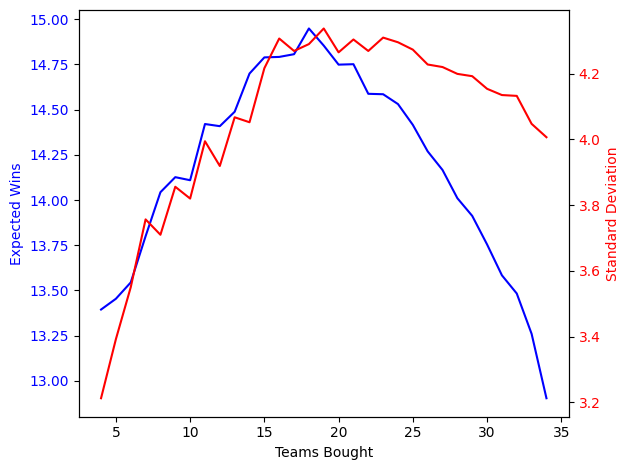

In [21]:
# Plot results

fig, ax1 = plt.subplots()

ax1.set_xlabel('Teams Bought')

ax1.plot(results_df.index, results_df.Exp_Wins, color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_ylabel('Expected Wins', color="blue")

ax2 = ax1.twinx()
ax2.plot(results_df.index, results_df.Std_Dev, color="red")
ax2.tick_params(axis='y', labelcolor="red")
ax2.set_ylabel('Standard Deviation', color="red")

fig.tight_layout()
plt.show()

Expected wins and variance of results both maximized when buying ~18 teams. This means our best chance of achieving 18 wins should occur around here.

Note that variance is very small when buying a low number of teams (makes sense), quickly increases, and then starts to steadily decrease once teams bought exceeds ~23. Perhaps because ballots with that many teams have all very low (10+) seeds, which most often lose in first round?

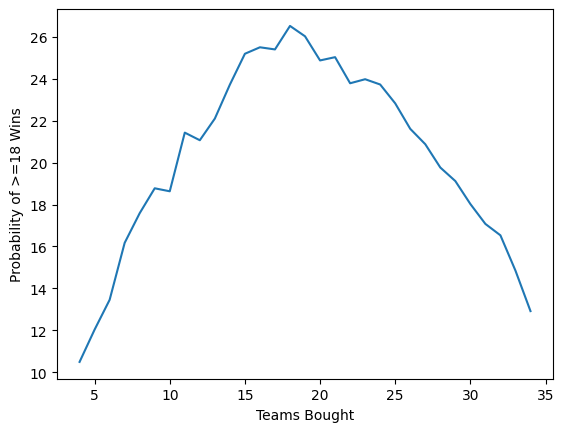

In [22]:
# Plot probability of >=18 wins
plt.plot(results_df.index, results_df["Prob >=18W"])
plt.xlabel('Teams Bought')
plt.ylabel('Probability of >=18 Wins')
plt.show()

Agrees with the graph above. Win probability maximized very clearly around ~18 teams bought, at around 26.5% from project's tournament simulation logic.